In [467]:
import numpy as np
import math
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from hamming import *
from encode import *

%matplotlib inline

## Constants

In [497]:
sample_rate = 1e6

Make sure data is in float32

In [498]:
stuff=np.fromfile('./rx_bits.txt',dtype='float32')
#header=np.fromfile('./header.dat',dtype='float32')
header = generate_white_noise(seed=4)
footer = generate_white_noise(seed=5)

Take real and imaginary parts of complex signal

In [499]:
arr1 = stuff[::2]
arr2 = stuff[1::2]

Make a complex signal

In [500]:
signal=arr1+(1j * arr2 )

Real signal plot

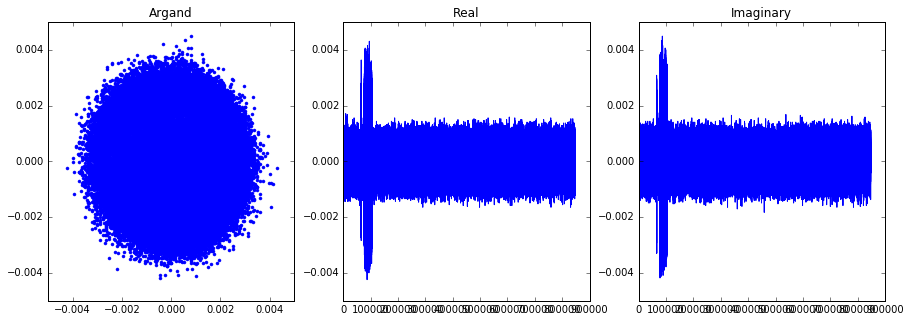

In [501]:
fullPlot(signal)

Calculate the frequency axis of the fft, then calculate the fft of the signal squared. Half of the frequency of the spike is an approximation of the frequency offset.

(1.25606237443e-06-3.90537500485e-08j)
start: 76606
end: 98566


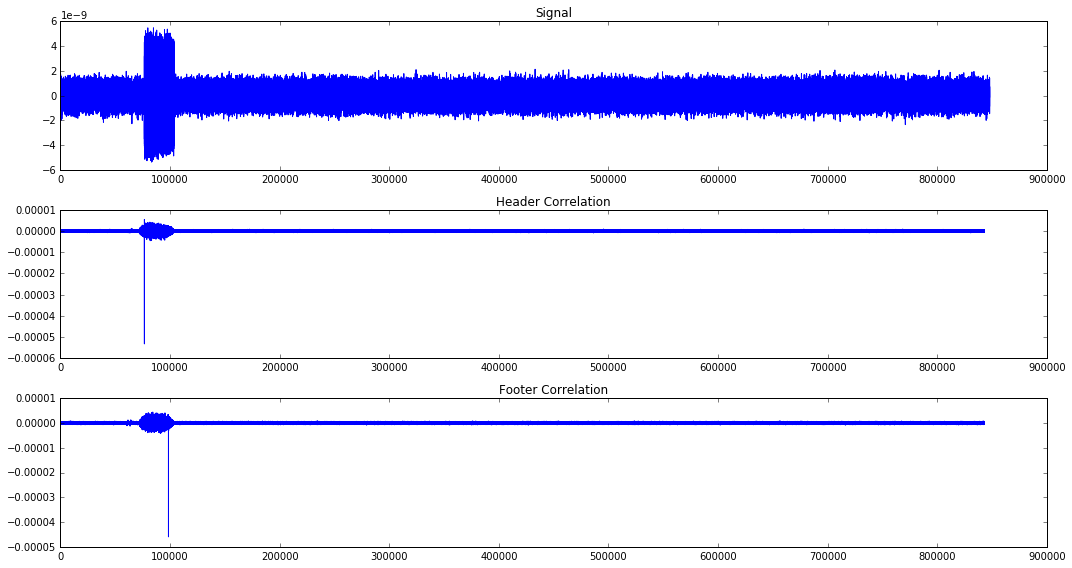

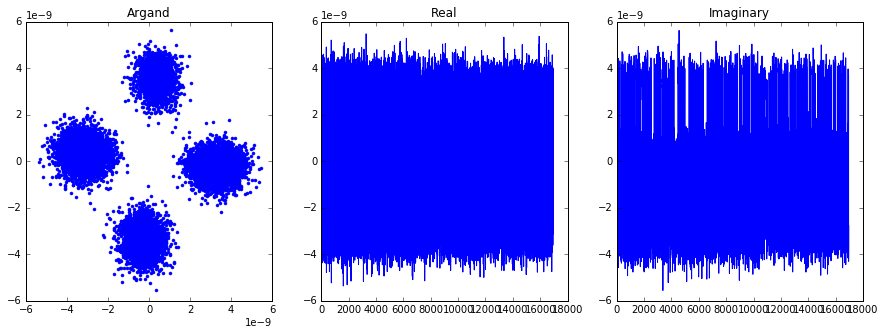

In [502]:
trimmed = autoTrim(signal,header,footer)
fullPlot(trimmed)

### Costas Loop
To correct for phase drift, the Costas loop uses the area of the rectangle formed by our complex vector as an error function. We're not actually using a Costas loop, since we can get a more exact phase correction using nonlinear python operations. 

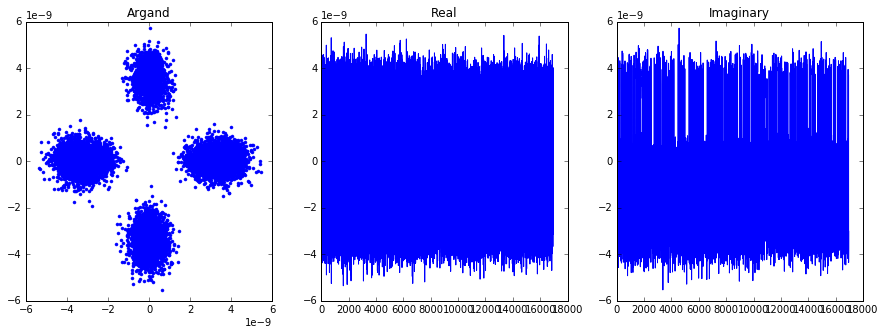

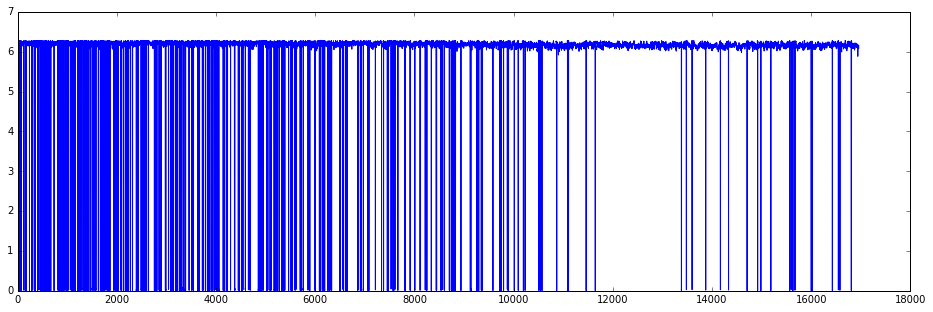

In [503]:
phase_captured, phase_o = phaseCapture(trimmed)
fullPlot(phase_captured)
plt.figure(figsize=(16,5))
plt.plot(phase_o)

3392
[2, 1, 0, 3]


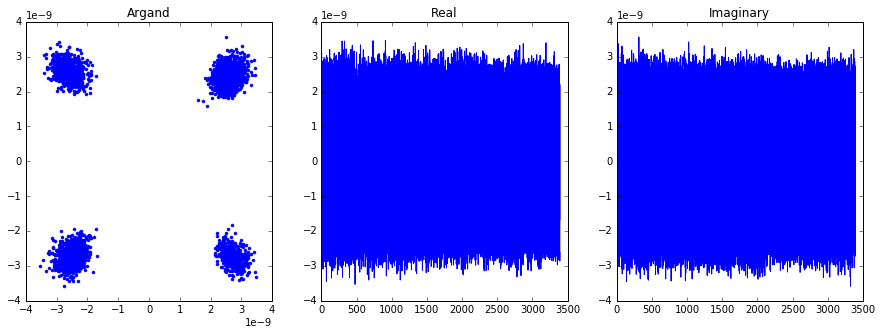

In [516]:
sampled=sample(phase_captured)
print(len(sampled))
res = autoRotate(sampled*np.exp(-1j*np.pi/4), threshold=0.0000000001)
fullPlot(res)

In [517]:
received_bits = list(parse(res,threshold = 0.0000000001))
# received_bits[251] = 2
# received_bits[252] = 0
# received_bits[250] = 3
# print(received_bits[250])
# received_bits

In [518]:
unHam(received_bits)

'ShallIcomparetheetoasummersdayThouartmorelovelyandmoretemperateRoughwindsdoshakethedarlingbudsofMayAndsummersleasehathalltooshortadateSometimetoohottheeyeofheavenshinesAndoftenishisgoldcomplexiondimmdAndeveryfairfromfairsometimedeclinesBychanceornatureschangingcourseuntrimmdButthyeternalsummershallnotfadeNorlosepossessionofthatfairthouowstNorshallDeathbragthouwanderstinhisshadeWhenineternallinestotimethougrowstSolongasmencanbreatheoreyescanseeSolonglivesthisandthisgiveslifetothee'

In [519]:
dePorkify(received_bits)

[0 1 0 ..., 1 0 1]


'ShallIcomparetheetoasummersdayThouartmorelovelyandmoretemperateRoughwindsdoshakethedarlingbudsofMayAndsummersleasehathalltooshortadateSometimetoohottheeyeofheavenshinesAndoftenishisgoldcomplexiondimmdAndeveryfairfromfairsometimedeclinesBychanceornatureschangingcourseuntrimmdButthyeternalsummershallnotfadeNorlosepossessionofthatfairthouowstNorshallDeathbragthouwanderstinhisshadeWhenineternallinestotimethougrowstSolongasmencanbreatheoreyescanseeSolonglivesthisandthisgiveslifetothee'

In [520]:
# parsed = list(parse(res,threshold = 0.001))

In [521]:
expectation = [1, 0, 2, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 2, 1, 2, 0, 1, 2, 1, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 0, 1, 3, 2, 0, 0, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 2, 1, 2, 1, 1, 0, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 3, 3, 0, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 0, 1, 3, 2, 0, 0, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 1, 0, 2, 2, 2, 2, 2, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 1, 3, 0, 0, 0, 1, 3, 2, 0, 3, 3, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 2, 2, 2, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 0, 3, 0, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 1, 0, 2, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 2, 1, 2, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 2, 1, 2, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 0, 1, 3, 2, 0, 0, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 0, 3, 0, 2, 1, 2, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 1, 2, 1, 2, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 2, 1, 2, 0, 2, 2, 2, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 0, 1, 3, 2, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2, 0, 1, 3, 3, 0, 3, 0, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 0, 1, 3, 2, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 0, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 2, 1, 2, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 0, 3, 3, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 2, 1, 2, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 2, 2, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 0, 3, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 0, 1, 3, 2, 0, 3, 3, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 1, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 1, 0, 2, 2, 0, 3, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 1, 1, 3, 0, 3, 0, 0, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 0, 3, 3, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 1, 0, 2, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 2, 2, 2, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 2, 1, 2, 1, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 0, 0, 3, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 2, 1, 1, 1, 0, 2, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 1, 2, 2, 1, 3, 0, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 3, 0, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 1, 2, 1, 0, 1, 3, 3, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 0, 3, 1, 2, 1, 2, 3, 0, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 3, 0, 3, 0, 2, 1, 1]

In [522]:
# received_bits = parsed
if len(expectation) != len(received_bits):
    print('padding')
    print(len(expectation),len(received_bits))
    expectation = [-1] * np.absolute(len(received_bits)-len(expectation)) + expectation

# print(expectation)
error = [bin(a^b).count("1") for a,b in zip(expectation, received_bits)]
# print(error)

padding
(3388, 3392)


In [523]:
# print(received_bits)

In [524]:
# print(expectation)

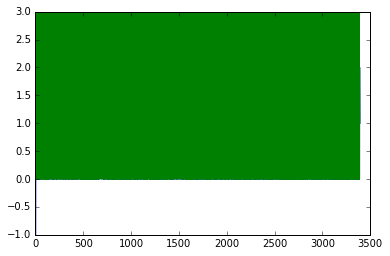

In [525]:
plt.plot(expectation)
plt.plot(received_bits)

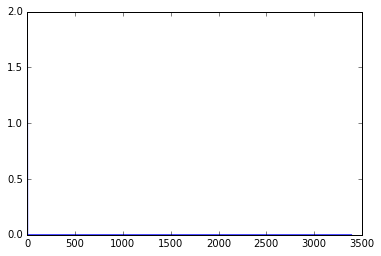

In [526]:
plt.plot(error)

In [527]:
# print(error)

## Playground

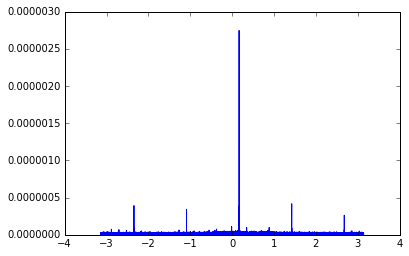

In [495]:
freq_data=np.fft.fftshift(np.fft.fft(signal**4))
freq_axis=np.fft.fftfreq(len(signal),(1/sample_rate))
rad_axis= np.linspace(-np.pi, np.pi*(len(signal)-1)/len(signal), len(freq_data))
plt.plot(rad_axis,np.absolute(freq_data))

In [496]:
freq_offset=np.argmax(freq_data)/4
print("The frequency offset is {:06.2f} hertz".format(freq_axis[np.argmax(freq_data)]/4))
offset = rad_axis[np.argmax(freq_data)]/4
print("The frequency offset is {:06.5f} radians".format(offset))

The frequency offset is -118333.42 hertz
The frequency offset is 0.04189 radians


## Functions

In [3]:
def approxPhaseCorrect(raw_sig,rate=sample_rate,verbose=False):
    """Applies a approximate phase correction to a complex signal, returning the corrected signal"""
    duration = len(raw_sig)
    freq_data = np.fft.fftshift(np.fft.fft(raw_sig**4))
    rad_axis= np.linspace(-np.pi, np.pi*(duration-1)/duration, len(freq_data))
    if verbose:
        pass
    peak = np.argmax(freq_data)
    print(freq_data[peak])
    offset = rad_axis[peak]/4
    correction = -np.exp(-1j*np.linspace(0,duration-1,duration)*offset)
    return raw_sig*correction*freq_data[peak]

def generate_white_noise(seed=None):
    mean = 0
    std = 1
    num_samples = 5000
    np.random.seed(seed)
    samples = np.random.normal(mean, std, size=num_samples)
    header=samples + (1j * samples)
    return header

In [4]:
def argand(signal):
    """Plots an argand diagram of a complex signal"""
    plt.plot(np.real(signal),np.imag(signal), marker='.',linestyle='')
    
def fullPlot(signal):
    """Plots an argand diagram of a complex signal, along with the real and complex components in time"""
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(131)
    argand(signal)
    ax1.set_title('Argand')
    
    ax2 = plt.subplot(132)
    plt.plot(np.real(signal))
    ax2.set_title('Real')
    #ax2.set_xticks(ax2.get_xticks()[::2]) #Remove half ticks for long signals
    
    ax3 = plt.subplot(133)
    plt.plot(np.imag(signal))
    ax3.set_title('Imaginary')
    #ax3.set_xticks(ax3.get_xticks()[::2])
    plt.show()

In [5]:
def autoTrim(raw_signal, header, footer):
    signal = approxPhaseCorrect(raw_signal)
    header_corr = np.correlate(signal, header, mode="valid")
    footer_corr = np.correlate(signal, footer, mode="valid")
    start_time = np.argmax(np.absolute(header_corr))
    end_time = np.argmax(np.absolute(footer_corr))
    trimmed = signal[start_time+len(header):end_time]
    
    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(311)
    ax1.set_title('Signal')
    plt.plot(np.real(signal))
    ax2 = plt.subplot(312)
    ax2.set_title('Header Correlation')
    plt.plot(np.real(header_corr))
    ax3 = plt.subplot(313)
    plt.plot(np.real(footer_corr))
    ax3.set_title('Footer Correlation')
    #     plt.subplot(414)
    #     plt.plot(np.real(trimmed))
    fig.tight_layout()
    
    print("start: {}".format(start_time))
    print("end: {}".format(end_time))
    
    return trimmed

In [6]:
def parse(signal, threshold=0.001):
    for sample in signal:
        if np.absolute(np.real(sample))+np.absolute(np.imag(sample)) < threshold:
            yield(-1)
            continue
        if np.real(sample) < 0:
            if np.imag(sample) < 0:
                yield(0)
            else:
                yield(1)
        else:
            if np.imag(sample) < 0:
                yield(2)
            else:
                yield(3)

In [348]:
def sample(signal, offset=1, bucket=2, period=5):
    length = len(signal)
#     print(length)
    num_pads = int(period * np.ceil(float(length)/period))-length
#     pads = (int(np.floor(num_pads/2)), int(np.ceil(num_pads/2)))
    signal_padded = np.pad(signal, (0,num_pads), 'constant', constant_values=np.NaN)
    signal_reshaped = np.reshape(signal_padded, (-1, period))
    signal_sliced = signal_reshaped[:, range(offset, offset+bucket+1)]
    signal_mean = np.nanmean(signal_sliced, axis=1)
    return signal_mean

In [302]:
def phaseCapture(signal):
    phase_captured = []
    phase_offset_t = []
    phase_offset = 0
    corrected_sample = 0
    avg_mag = np.mean([np.absolute(p) for p in signal])
    measured_offset = 0

    for point in signal:
        if np.absolute(point) > 0.25 * avg_mag:
            # apply previous correction factor
            corrected_sample = point * np.exp(-1j*phase_offset)

            received_angle = np.angle(corrected_sample) # range from -pi to pi
            received_angle += 2 * np.pi # Correct to range of 0 to 2 pi

            #calculate multiples of pi/2 the received was offset from 0
            num_quadrants = np.floor((received_angle + np.pi / 4) / (np.pi / 2) )
            original_angle = np.pi * num_quadrants / 2

            #calculate received angle offset from intended angle
            measured_offset = received_angle - original_angle

        # add forgetting factor
        phase_offset = phase_offset + 0.2 * measured_offset

        # wrap phase_offset from 0 to -2 pi
        while (phase_offset > 2 * np.pi):
            phase_offset = phase_offset - 2 * np.pi
        while (phase_offset < 0):
            phase_offset = phase_offset + 2 * np.pi

        #apply final correction factor and output
        phase_captured.append(point * np.exp(-1j*phase_offset))
        phase_offset_t.append(phase_offset)

    return phase_captured, phase_offset_t

In [9]:
def decode_string(quad_arr):
    if len(quad_arr) % 4 != 0: return 'ERR'
    idx = 0
    curr_ord = 0
    output_string = ''
    shift = 0
    for symbol in quad_arr:
        curr_ord += symbol << (3-shift)*2
        shift = (shift + 1) % 4
        if shift == 0:
            try:
                output_string += (chr(curr_ord))
            except ValueError:
                output_string += 'FUCK'
            curr_ord = 0
    return output_string

In [418]:
def autoRotate(signal, header=None, threshold=0.001):
    """Automatically rotates a sampled signal to match a given header. Raises an error if not."""
    if header==None:
        header = [0,3,1,2]
    lowest = 100 
    best = None
    check = signal[:len(header)]
    print(list(parse(check, threshold=threshold)))
    
    for x in [1, 1j, -1, -1j]: #rotations
        tmp = sum([bin(a^b).count("1") for a,b in zip(parse(check * x, threshold=threshold), header)])
        if tmp < lowest:
            best = x
            lowest = tmp
        
    if lowest != 0:
        print(best)
        print(lowest)
        print("Probably errors..")
    return signal*best
    

In [273]:
def unHam(signal,header=None):
    if header==None:
        header=[0,3,1,2]
    rx = np.array(decode_bit_stream(signal[len(header):])).flatten()
    errors = hamming_error_check2(rx)
#     print(errors)
    err_tmp = calcerror(errors).flatten()
#     print err_tmp
    rx_corrected = hamming_correct2(rx, err_tmp).flatten()
    bits_decode = hamming_decode(rx_corrected).flatten()
#     print (bits_decode)


    #     return frombits(bits_decode)
    return frombits(bits_decode)

In [180]:
def dePorkify(signal, header=None):
    if header==None:
        header=[0,3,1,2]
    rx = np.array(decode_bit_stream(signal[len(header):])).flatten()
    bits_decode = hamming_decode(rx).flatten()
    print (bits_decode)

    return frombits(bits_decode)

In [277]:
def hamming_correct2(res, errs):
    arr = np.zeros((len(errs),7))
    resh = np.copy(np.reshape(res, (-1,7)))
    for i,e in enumerate(errs):
        if e > 0:
            print('bit', e)
#             print(resh[i])
            resh[i,e-1] = 1-resh[i,e-1]
#             print(resh[i])
    return resh

In [173]:
def hamming_error_check2(bits):
    bits_reshaped = np.reshape(bits, (-1, 7)).transpose()
    errors = np.dot(H,bits_reshaped)%2
    return np.fliplr(errors.transpose())